In [1]:
%matplotlib inline

In [2]:
import json
import math
import os
import random
import time
from collections import Counter, namedtuple
from itertools import count
from typing import Dict, Optional
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from env import GameEnv

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DuelingDQN(nn.Module):
    def __init__(self, input_shape, outputs):
        super(DuelingDQN, self).__init__()

        self.fn1 = nn.Linear(input_shape, 300)
        self.fn2 = nn.Linear(300, 300)
        self.fn3 = nn.Linear(300, 200)
        self.fn4 = nn.Linear(200, 200)
        self.fn5 = nn.Linear(200, 100)
        # self.fn6 = nn.Linear(100, 100)

        self.adv1 = nn.Linear(100, 100)
        self.adv2 = nn.Linear(100, outputs)

        self.val1 = nn.Linear(100, 60)
        self.val2 = nn.Linear(60, 1)

    def forward(self, x):
        x = F.relu(self.fn1(x.view(x.size(0), -1)))
        x = F.relu(self.fn2(x))
        x = F.relu(self.fn3(x))
        x = F.relu(self.fn4(x))
        x = F.relu(self.fn5(x))

        adv = F.relu(self.adv1(x))
        adv = self.adv2(adv)

        val = F.relu(self.val1(x))
        val = self.val2(val)

        return val + adv - adv.mean()

In [5]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [7]:
def train(num_episodes):
    for i_episode in range(num_episodes):
        env.reset()

        current_board = get_state(env)
        old_board = get_state(env)
        
        for t in count():
            action = select_action(current_board)
            _, reward, done, _ = env.step(action.item())
            if reward > 1 or reward < -1:
                print("reward not normalized")
            reward = torch.tensor([reward], device=device)

            current_board = get_state(env)

            if not done:
                next_state = current_board
            else:
                next_state = None

            memory.push(old_board, action, next_state, reward)

            optimize_model()
            if done:
                episode_scores.append(env.score)
                highest_scores.append(env.highest())
                plot_scores()
                break
                
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

In [8]:
def plot_scores(save=None):
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(highest_scores, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Highest Scores')
    plt.plot(scores_t.numpy())
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

    plt.pause(0.001)  # pause a bit so that plots are updated

    display.clear_output(wait=True)

In [9]:
def write_results(log_dir):
    try:
        os.makedirs(log_dir)
    except OSError:
        pass
    plot_scores(save=f"{log_dir}/plot.png")
    torch.save(target_net, f"{log_dir}/target.pt")
    torch.save(policy_net, f"{log_dir}/policy.pt")
    torch.save(optimizer, f"{log_dir}/optimizer.pt")

    with open(f"{log_dir}/highest_scores.json", "w") as json_file:
        scores = {str(k): v for k, v in Counter(
            highest_scores).items()}
        print(scores)
        json.dump(scores, json_file)

In [10]:
def evaluate(steps):
    episode_scores = []
    highest_scores = []
    for i in range(steps):
        env.reset()
        steps_done = 0
        for t in count():
            with torch.no_grad():
                action = policy_net(get_state(env)).max(1)[1].view(1, 1)
            board, reward, done, info = env.step(action.item())
            steps_done += 1
            if done or steps_done > 2000:
                if steps_done > 2000:
                    print("max steps reached")
                env.render()
                episode_scores.append(env.score)
                highest_scores.append(env.highest())
                break
    print(Counter(highest_scores))
    plt.plot(highest_scores)

In [11]:
num_episodes = 1000
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
MEMORY_SIZE = 10000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Start training setup

In [12]:
# 4*16 matrix
def get_state(env: GameEnv):
    with np.errstate(divide='ignore'):
        board = np.where(env.board != 0, np.log2(env.board).astype(np.int), 0)
    board = np.vectorize(np.binary_repr)(board, width=4).astype(str)
    board = np.array([list(''.join(line)) for line in board]).astype(np.int)
    return torch.from_numpy(np.ascontiguousarray(board)).unsqueeze(0).float().to(device)

In [13]:
class Reward1():
    @staticmethod
    def reward_function(score) -> float:
        return score / 80
    
    @staticmethod
    def tile_merge_reward(value_pair) -> float:
        return np.log2(value_pair[0])

    @staticmethod
    def final_state_reward(score: float = None) -> float:
        return 0.

    @staticmethod
    def invalid_move_reward() -> float:
        return 0.

env = GameEnv(reward_class=Reward1)

In [14]:
episode_scores = []
highest_scores = []
memory = ReplayMemory(MEMORY_SIZE)
steps_done = 0
n_actions = env.action_space.n
policy_net = DuelingDQN(4*16, n_actions).to(device)
target_net = DuelingDQN(4*16, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)

In [15]:
import logging
logging.basicConfig(level=logging.DEBUG, filename="run.log")

In [16]:
for i in range(10):
    train(num_episodes)
    write_results(f"runs/dueling_qn3/{i}")

{'64': 4316, '128': 3918, '32': 1210, '256': 440, '16': 112, '8': 4}


/home/matei/anaconda3/envs/RL/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type DuelingDQN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


max steps reached
Score: 0.0
Highest: 4
[[0 0 4 2]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]]
max steps reached
Score: 0.05
Highest: 4
[[0 0 2 4]
 [0 4 2 4]
 [0 0 2 4]
 [0 0 2 4]]
max steps reached
Score: 0.05
Highest: 8
[[0 0 2 4]
 [0 0 0 0]
 [0 0 2 8]
 [0 0 0 2]]
max steps reached
Score: 0.16250000000000003
Highest: 8
[[2 4 2 8]
 [0 0 0 2]
 [0 0 4 8]
 [0 0 2 8]]
max steps reached
Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 0]
 [0 0 0 4]
 [0 0 4 2]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 4 2]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 0]]
max steps reached
Score: 0.037500000000000006
Highest: 8
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 8]
 [0 0 0 0]]
max steps reached
Score: 0.037500000000000006
Highest: 4
[[0 0 0 4]
 [0 0 2 4]
 [0 0 2 4]
 [0 0 0 2]]
max steps reached
Score: 0.16249999999999998
Highest: 8
[[0 0 8 2]
 [0 0 0 8]
 [0 0 2 4]
 [0 0 4 

max steps reached
Score: 0.0125
Highest: 4
[[0 0 2 4]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 0 4]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 0 4]
 [0 0 0 4]
 [0 0 2 4]]
max steps reached
Score: 0.15
Highest: 8
[[0 0 2 8]
 [0 0 0 2]
 [0 0 2 8]
 [0 0 2 8]]
max steps reached
Score: 0.125
Highest: 8
[[0 0 2 8]
 [0 0 2 4]
 [0 0 2 4]
 [0 0 2 8]]
max steps reached
Score: 0.08750000000000001
Highest: 8
[[0 0 0 4]
 [0 0 2 4]
 [0 0 2 4]
 [0 0 0 8]]
max steps reached
Score: 0.037500000000000006
Highest: 4
[[0 0 0 4]
 [0 0 0 4]
 [0 0 2 4]
 [0 0 2 4]]
max steps reached
Score: 0.1
Highest: 8
[[0 0 0 2]
 [0 0 2 8]
 [0 0 0 8]
 [0 4 2 4]]
max steps reached
Score: 0.21250000000000005
Highest: 8
[[0 2 4 8]
 [0 0 0 8]
 [0 0 2 8]
 [0 0 2 8]]
max ste

max steps reached
Score: 0.0
Highest: 4
[[0 0 0 0]
 [0 0 0 2]
 [0 2 4 2]
 [0 2 4 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 2 4]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 4]]
max steps reached
Score: 0.08750000000000001
Highest: 8
[[0 0 2 4]
 [0 0 2 4]
 [0 0 0 8]
 [0 0 2 4]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 2 4]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 4]
 [0 0 2 4]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 0]
 [0 0 0 2]
 [0 0 2 4]
 [0 0 0 0]]
max steps reached
Score: 0.1625
Highest: 8
[[0 0 2 8]
 [0 0 4 8]
 [0 4 2 4]
 [0 0 2 8]]
max steps reached
Score: 0.1
Highest: 8
[[0 0 0 2]
 [0 0 2 8]
 [4 2 4 2]
 [0 0 0 8]]
max steps reached
Score: 0.15
Highest: 8
[[0 0 0 8]
 [0 2 8 2]
 [0 0 2 8]
 [0 0 2 4]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 4 2]]
max steps reached
Score: 0.025
Hi

max steps reached
Score: 0.0625
Highest: 8
[[0 0 2 4]
 [0 0 2 8]
 [0 0 4 2]
 [0 0 2 4]]
max steps reached
Score: 0.11249999999999999
Highest: 8
[[0 0 0 8]
 [0 0 2 4]
 [0 0 0 8]
 [0 0 2 4]]
max steps reached
Score: 0.3875
Highest: 16
[[ 0  2  4  8]
 [ 0  0  4  8]
 [ 0  0  4 16]
 [ 0  0  4 16]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 2 4]
 [0 0 0 0]
 [0 0 2 4]
 [0 0 0 4]]
max steps reached
Score: 0.31250000000000006
Highest: 16
[[ 0  2  4  8]
 [ 0  0  4  8]
 [ 0  0  2 16]
 [ 0  2  4  8]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 0 2]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 4]]
max steps reached
Score: 0.037500000000000006
Highest: 8
[[0 0 0 2]
 [0 0 2 4]
 [0 0 0 0]
 [0 0 2 8]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 2 4]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 0 0]]
max steps reached
Score: 0.05
Highest: 8
[[0 0 0 0]
 [0 0 0 8]
 [0 0 0 2]
 [0 0 0 4]]
max steps reached
Score: 0
Highest: 2
[[0 0 0 2]
 [0

max steps reached
Score: 0
Highest: 2
[[0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 4 2]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.16249999999999998
Highest: 8
[[0 0 2 4]
 [0 2 4 8]
 [0 2 4 8]
 [0 0 2 8]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 4]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 2 4]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]]
max steps reached
Score: 0.05
Highest: 8
[[0 0 2 4]
 [0 0 0 4]
 [0 2 8 2]
 [0 0 0 2]]
max steps reached
Score: 0.0875
Highest: 8
[[0 0 2 4]
 [0 4 2 4]
 [0 0 2 8]
 [0 0 2 4]]
max steps reached
Score: 0.6
Highest: 16
[[ 0  0  0 16]
 [ 0  0  4 16]
 [ 0  4  8 16]
 [ 2  4  2 16]]
max steps reached
Score: 0.07500000000000001
Highest: 8
[[0 0 2 4]
 [0 0 2 4]
 [0 0 0 8]
 [0 0 2 4]]
max steps reached
Score: 0.07500000000000001
Highest: 8
[[0 0 2 4]
 [0 0 0 2]
 [0 0 2 4]
 [0 0 2 8]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0

max steps reached
Score: 0.075
Highest: 8
[[0 0 4 8]
 [0 0 0 4]
 [0 0 2 4]
 [0 0 0 2]]
max steps reached
Score: 0.037500000000000006
Highest: 4
[[0 0 2 4]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 4]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 4]
 [0 0 0 2]
 [0 0 2 4]
 [0 0 0 0]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 0 4]
 [0 0 2 4]
 [0 0 4 2]
 [0 0 4 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 2 4]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 4]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 0]]
max steps reached
Score: 0.13749999999999998
Highest: 8
[[0 0 4 2]
 [0 0 0 4]
 [0 2 4 8]
 [0 0 4 8]]
max steps reached
Score: 0.0625
Highest: 8
[[0 0 2 8]
 [0 0 0 2]
 [0 0 2 4]
 [0 2 4 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 4]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 0 2]
 [0 0 0 4]
 [0 0 4 2]
 [0 0 0 4]]
max steps reached
Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]]
max steps reache

max steps reached
Score: 0.15
Highest: 8
[[0 0 2 8]
 [0 0 0 8]
 [0 0 2 4]
 [0 0 2 8]]
max steps reached
Score: 0.11250000000000002
Highest: 8
[[0 0 0 8]
 [0 0 2 8]
 [0 2 4 2]
 [0 0 2 4]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 4]]
max steps reached
Score: 0.037500000000000006
Highest: 4
[[0 0 0 4]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 2 4]]
max steps reached
Score: 0
Highest: 4
[[0 0 0 0]
 [0 0 0 4]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 4 2]]
max steps reached
Score: 0.0625
Highest: 8
[[0 0 0 4]
 [0 0 0 8]
 [0 0 0 4]
 [0 0 2 4]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0625
Highest: 8
[[0 0 0 4]
 [0 0 2 8]
 [0 0 2 4]
 [0 0 0 4]]
max steps reached
Score: 0.037500000000000006
Highest: 8
[[0 0 0 0]
 [0 0 2 8]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 4]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]]

max steps reached
Score: 0.0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 0]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.05
Highest: 8
[[0 0 2 4]
 [0 0 4 8]
 [0 0 0 4]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 4 2]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 2 4]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 4]]
max steps reached
Score: 0.11250000000000002
Highest: 8
[[0 0 2 8]
 [0 0 2 8]
 [0 2 4 2]
 [0 0 0 4]]
max steps reached
Score: 0.13749999999999998
Highest: 8
[[0 0 0 4]
 [0 0 4 8]
 [0 0 0 4]
 [0 0 2 8]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 4]]
max steps reached
Score: 0.075
Highest: 8
[[0 0 2 8]
 [0 0 0 4]
 [0 2 4 2]
 [0 0 2 4]]
max steps reached
Score: 0.0625
Highest: 8
[[0 0 0 0]
 [0 2 8 2]
 [0 0 2 4]
 [0 0 2 4]]
max steps reached
Score: 0.037500000000000006
Highest: 4
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 2 4]]
max

max steps reached
Score: 0.025
Highest: 4
[[0 0 0 4]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.05
Highest: 8
[[0 0 2 8]
 [0 2 4 2]
 [0 0 2 4]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 0]
 [0 0 4 2]
 [0 0 0 4]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 0]
 [0 0 0 4]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0
Highest: 2
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [0 0 0 0]]
max steps reached
Score: 0.11249999999999999
Highest: 8
[[0 0 0 8]
 [0 0 2 4]
 [0 0 2 8]
 [0 0 4 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 2]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 2 4]
 [0 0 0 4]
 [0 0 2 4]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 4 2]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highe

max steps reached
Score: 0.037500000000000006
Highest: 8
[[0 0 0 2]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 0 8]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 0]]
max steps reached
Score: 0.037500000000000006
Highest: 4
[[0 0 0 4]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 0 4]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 0 2]
 [0 0 2 4]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 0]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 4 2]
 [0 0 2 4]
 [0 0 0 0]
 [0 0 0 2]]
max steps reached
Score: 0.1
Hig

max steps reached
Score: 0.025
Highest: 4
[[0 0 2 4]
 [0 0 0 2]
 [0 0 0 4]
 [0 0 2 4]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 0 2]
 [0 0 0 0]
 [0 2 4 2]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 0 4]
 [0 2 4 2]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0
Highest: 4
[[0 0 2 4]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 0 0]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 4]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 2 4]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 0]]
max steps reached
Score: 0.025
Highest: 4
[[0 0 0 2]
 [0 0 0 4]
 [0 0 0 2]
 [0 0 2 4]]
max steps reached
Score: 0.0
Highest: 2
[[0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]
 [0 0 0 2]]
max steps reached
Score: 0.0125
Highest: 4
[[0 0 0 2]
 [2 4 2 4]
 [0 0 2 4]
 [0 0 0 2]]
max steps reached
Score: 0.0875
Highest: 8
[[0

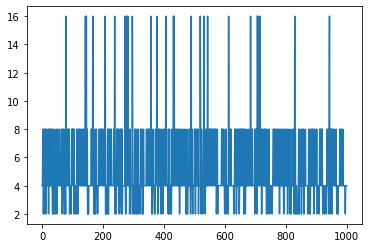

In [17]:
evaluate(1000)

In [21]:
class Reward2():
    @staticmethod
    def reward_function(score) -> float:
        return min(score/4., 1.)
    
#     number of tiles mergesd
    @staticmethod
    def tile_merge_reward(value_pair) -> float:
        return 1

    @staticmethod
    def final_state_reward(score: float = None) -> float:
        return -1.

    @staticmethod
    def invalid_move_reward() -> float:
        return 0.

env = GameEnv(reward_class=Reward2)

In [22]:
episode_scores = []
highest_scores = []
memory = ReplayMemory(MEMORY_SIZE)
steps_done = 0
n_actions = env.action_space.n
policy_net = DuelingDQN(4*16, n_actions).to(device)
target_net = DuelingDQN(4*16, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.RMSprop(policy_net.parameters())

In [23]:
for i in range(10):
    train(num_episodes)
    write_results(f"runs/dueling_qn2/{i}")

KeyboardInterrupt: 

In [ ]:
evaluate(100)

In [ ]:
# def state2tensor(state):
#     t = np.zeros((16, 16), dtype=np.float32)
#     for i, c in enumerate(state.flatten()):
#         t[c, i] = 1
#     t.resize(1, 16, 4, 4)
#     return t